# Preamble

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:0.23.23`
import $ivy.`org.http4s::http4s-dsl:0.23.23`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`

In [ ]:
import fs2.{Pipe, Pull, Stream}
import cats.effect.{IO, Async}
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._

In [ ]:
def stream[F[_]: cats.effect.kernel.Async](u: org.http4s.Uri): Stream[F, Json] = 
    import org.http4s.ember.client.EmberClientBuilder
    import io.circe.jawn.CirceSupportParser
    import org.http4s.headers.Authorization
    import org.http4s.{Method, Request}
    import org.typelevel.jawn.Facade
    import org.typelevel.jawn.fs2._

    given Facade[Json] = new CirceSupportParser(None, false).facade
    val bearerToken = scala.util.Properties.envOrElse("BEARER_GITHUB_TOKEN", "undefined")
    val authHeader =  Authorization(Credentials.Token(AuthScheme.Bearer, bearerToken))
    Stream.resource(EmberClientBuilder.default[F].build).flatMap{
        _.stream(Request[F](Method.GET, u).withHeaders(authHeader))
         .flatMap(_.body.chunks.parseJsonStream)
    }

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
extension [A](st: Stream[IO, A])
    def run: List[A] = 
        st.compile.toList.unsafeRunSync()

# Why should we want to embed `jq` in Scala?

### A simple streaming problem

`curl https://api.github.com/repos/hablapps/doric/commits?page=0`

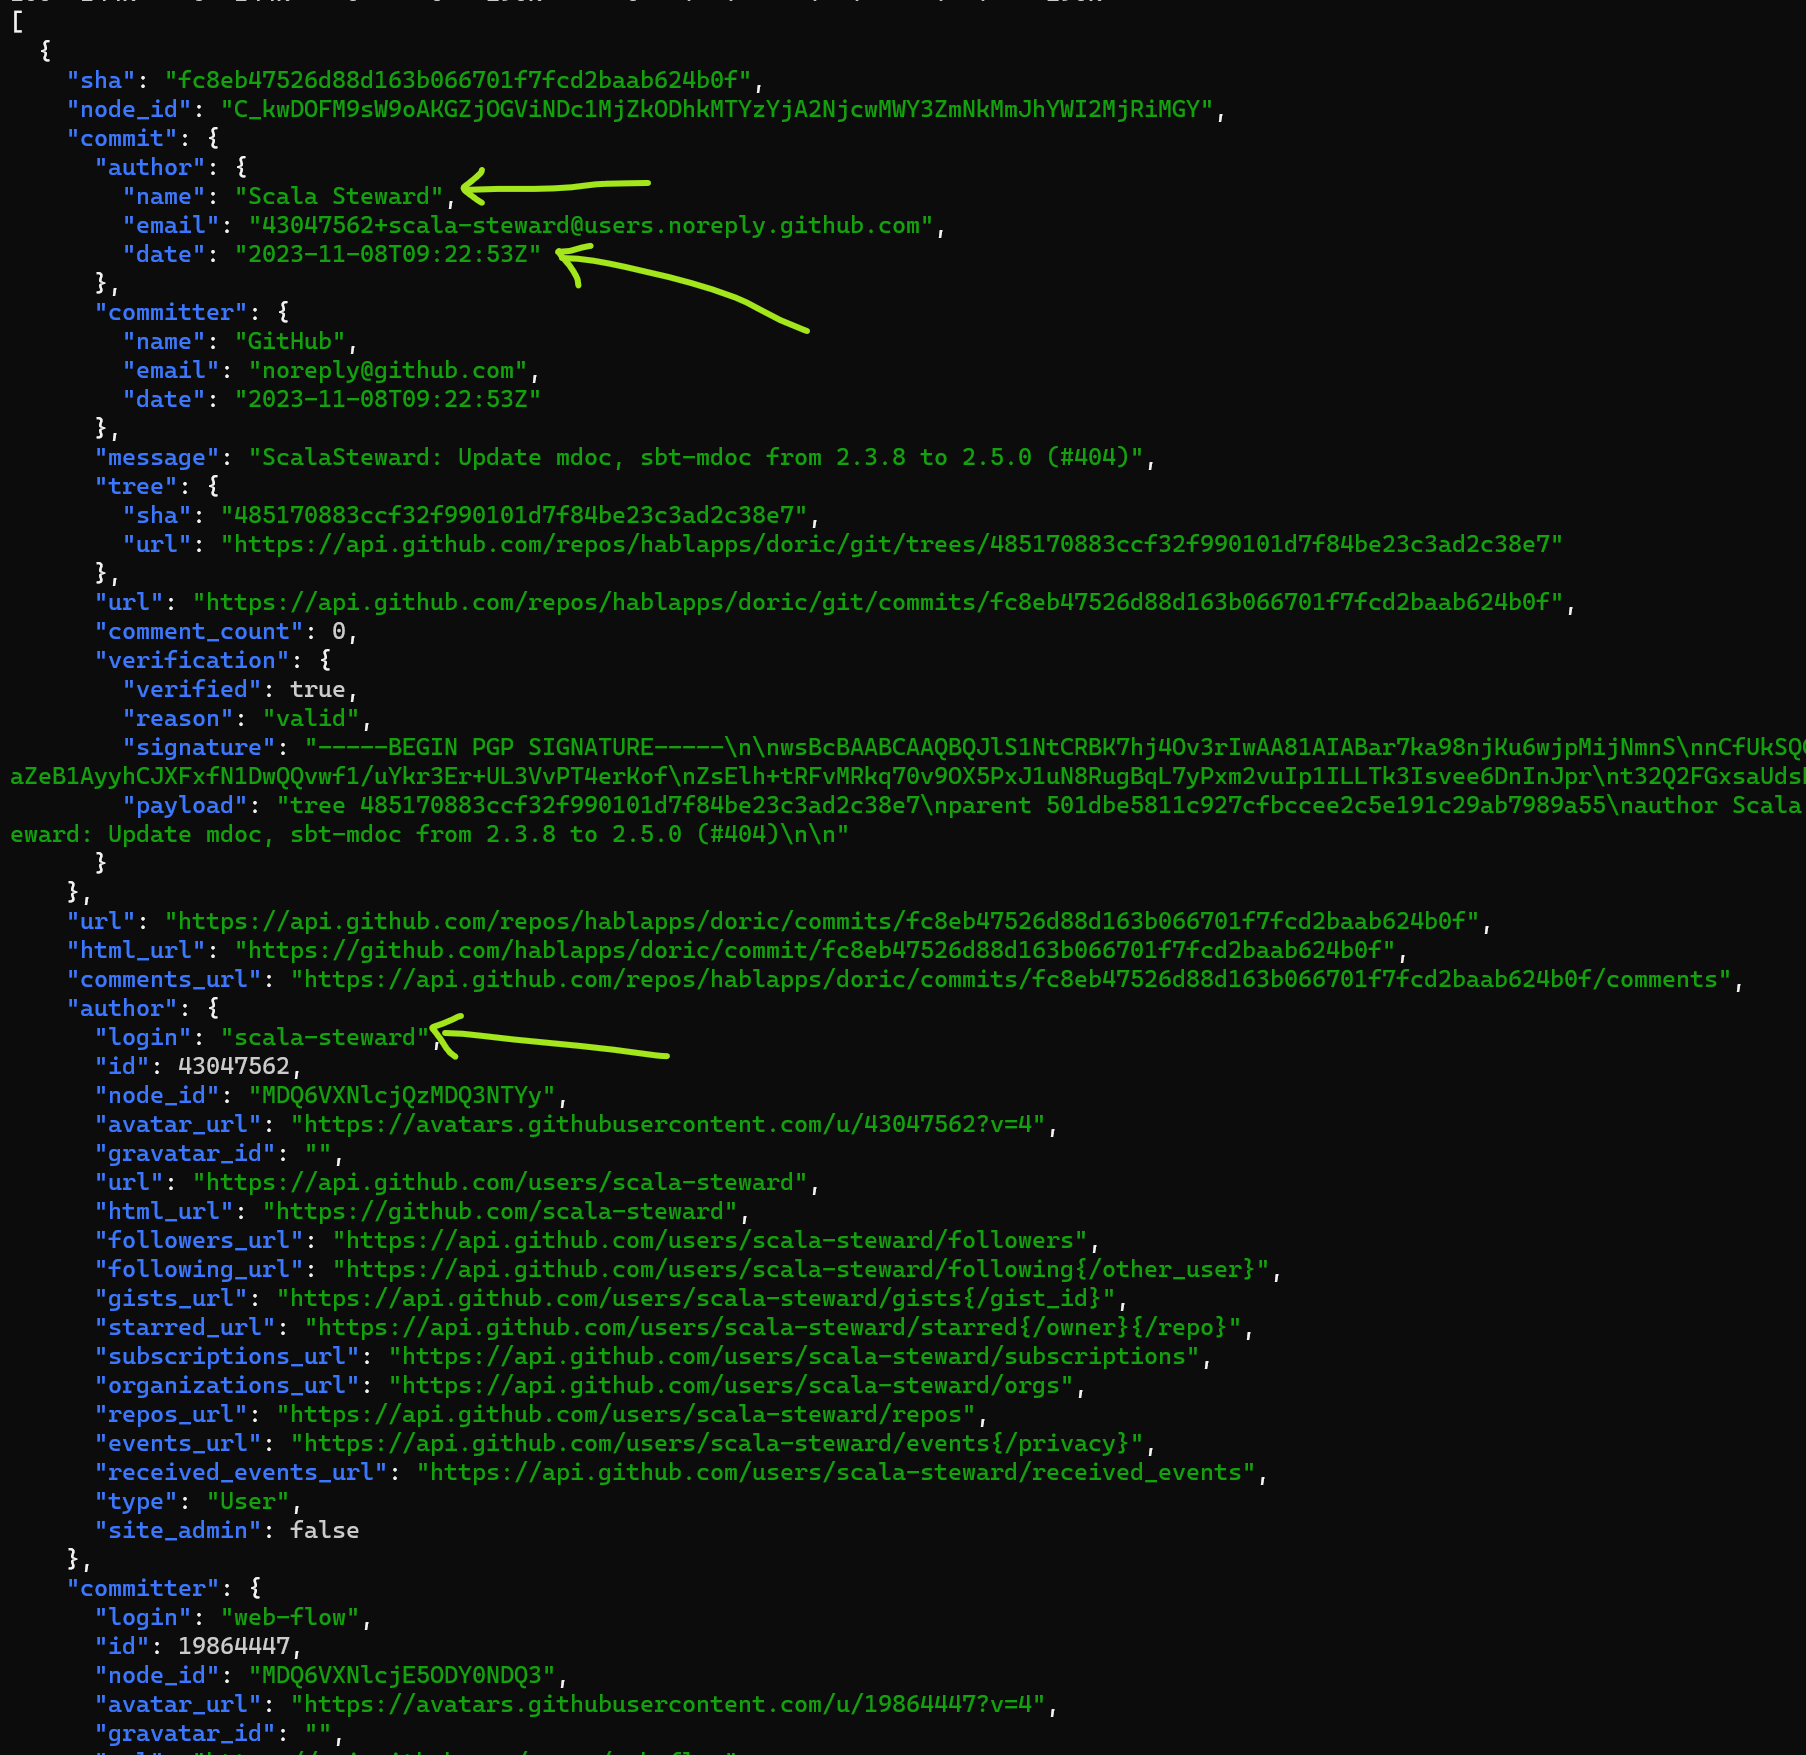

Two steps in the problem: stream creation and transformation.

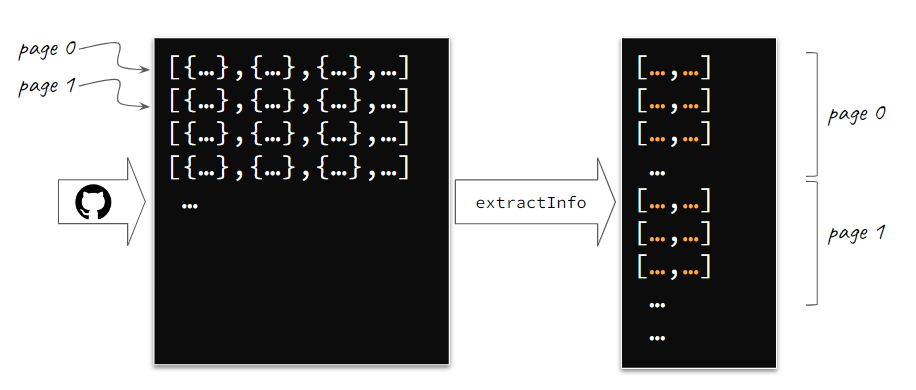

### `fs2` + `circe` + `monocle` solution

Please, set the OS environment variable `BEARER_GITHUB_TOKEN` with your personal access token in order to run these examples.

#### Stream generation

In [ ]:
def allCommitPages[F[_]: Async](repo: String): Stream[F, Json] =

    def newPage(i: Int): Stream[F, Json] = 
        stream(Uri.unsafeFromString(s"$repo/commits?page=$i"))
    
    def go(i: Int, s: Stream[F,Json]): Pull[F, Json, Unit] =
        s.pull.uncons.flatMap:
            case Some((hd,tl)) =>
                hd(0) match
                    case IsArray(Vector()) => Pull.done
                    case _ => Pull.output(hd) >> go(i+1, tl ++ newPage(i))
            case None => Pull.done

    go(1, newPage(0)).stream

#### Stream transformation

In [ ]:
def extractInfo[F[_]](pages: Stream[F, Json]): Stream[F, Json] = 
    pages.flatMap: page =>
         Stream(
             (root.each.author.login.json.getAll(page) zip 
              root.each.commit.author.date.json.getAll(page))
                 .map(Json.arr(_, _))*
         )

In [ ]:
val commitInfoResults: List[Json] = 
    allCommitPages[IO]("https://api.github.com/repos/hablapps/doric")
        .take(2)
        .through(extractInfo)
        .run

### `jq` solution

Jq does only tackle stream transformations:

`def extractInfo: .[]|[.author.login, .commit.author.date]`

# References

* Optics alternative to jq: https://chrispenner.ca/posts/traversal-systems
* `Jq`: https://jqlang.github.io/jq/
* `Monocle`: https://fs2.io/#/
* fs2: https://fs2.io/#/
* circe: https://github.com/circe/circe
* Github API: https://docs.github.com/en/rest?apiVersion=2022-11-28